In [95]:
import pandas as pd
import numpy 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image

# Add the scripts folder to the system path
import sys
repo_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
scripts_path = os.path.join(repo_root, "scripts")
sys.path.append(scripts_path)
# Import and execute the dataset download function
from download_image_dataset import download_dataset
download_dataset()


Dataset already exists. Skipping download.


# Dataset loading and cleaning

First we are going to load the dataset and inspect it using head() to get an idea of its structure, and then info() to get a summary and check datatypes as well as non-null counts.


In [98]:
df = pandas.read_csv('../data/lung_cancer.csv')

df.head()


,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,LUNG_CANCER
0,M,69,1,2,2,1,1,2,1,2,2,2,2,2,2,YES
1,M,74,2,1,1,1,2,2,2,1,1,1,2,2,2,YES
2,F,59,1,1,1,2,1,2,1,2,1,2,2,1,2,NO
3,M,63,2,2,2,1,1,1,1,1,2,1,1,2,2,NO
4,F,63,1,2,1,1,1,1,1,2,1,2,2,1,1,NO


In [100]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309 entries, 0 to 308
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   GENDER                 309 non-null    object
 1   AGE                    309 non-null    int64 
 2   SMOKING                309 non-null    int64 
 3   YELLOW_FINGERS         309 non-null    int64 
 4   ANXIETY                309 non-null    int64 
 5   PEER_PRESSURE          309 non-null    int64 
 6   CHRONIC DISEASE        309 non-null    int64 
 7   FATIGUE                309 non-null    int64 
 8   ALLERGY                309 non-null    int64 
 9   WHEEZING               309 non-null    int64 
 10  ALCOHOL CONSUMING      309 non-null    int64 
 11  COUGHING               309 non-null    int64 
 12  SHORTNESS OF BREATH    309 non-null    int64 
 13  SWALLOWING DIFFICULTY  309 non-null    int64 
 14  CHEST PAIN             309 non-null    int64 
 15  LUNG_CANCER            

We've confirmed that there are no null values in the dataset (309-non null for each column) but we will also check for duplicates and remove them from the dataset. We will also clean the datasets column names clearing any whitespace and replacing "_" with a space for consistency.

In [103]:
# Clean whitespace from column names
df.columns = df.columns.str.strip()
# Replace underscores with spaces in column names
df.columns = df.columns.str.replace('_', ' ', regex=False)

# Check for duplicates
has_duplicates = df.duplicated().any()

if has_duplicates:
    print("Duplicates found in the dataset.")
else:
    print("No duplicates found in the dataset.")

# Count and display how many duplicates there are
print('How many duplicates:', df.duplicated().sum())

# Remove duplicates from the DataFrame
df.drop_duplicates(inplace=True)

Duplicates found in the dataset.
How many duplicates: 33


In [105]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 276 entries, 0 to 283
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   GENDER                 276 non-null    object
 1   AGE                    276 non-null    int64 
 2   SMOKING                276 non-null    int64 
 3   YELLOW FINGERS         276 non-null    int64 
 4   ANXIETY                276 non-null    int64 
 5   PEER PRESSURE          276 non-null    int64 
 6   CHRONIC DISEASE        276 non-null    int64 
 7   FATIGUE                276 non-null    int64 
 8   ALLERGY                276 non-null    int64 
 9   WHEEZING               276 non-null    int64 
 10  ALCOHOL CONSUMING      276 non-null    int64 
 11  COUGHING               276 non-null    int64 
 12  SHORTNESS OF BREATH    276 non-null    int64 
 13  SWALLOWING DIFFICULTY  276 non-null    int64 
 14  CHEST PAIN             276 non-null    int64 
 15  LUNG CANCER            276 n

# Binary Encoding

Currently we know from the dataset description that

* 1 respresents 'NO'
* 2 represents 'YES'

We are going to change that to use binary encoding such that:

* 0 will represent 'NO'
* 1 will represent 'Yes'

Lung cancer and gender will also be changed to follow this format rather than using the yes/no label for lung cancer and for gender:

* 'F' will become 0
* 'M' will become 1

Our reason for doing this is for consistency across our features, and some of the models we will be using later require the features to be binary encoded (e.g., log regression).

In [108]:
df.replace({2: 1, 1: 0}, inplace=True)
df['LUNG CANCER'] = df['LUNG CANCER'].map({'YES': 1, 'NO': 0})
df['GENDER'] = df['GENDER'].map({'M': 1, 'F': 0})

df.head()

,GENDER,AGE,SMOKING,YELLOW FINGERS,ANXIETY,PEER PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,LUNG CANCER
0,1,69,0,1,1,0,0,1,0,1,1,1,1,1,1,1
1,1,74,1,0,0,0,1,1,1,0,0,0,1,1,1,1
2,0,59,0,0,0,1,0,1,0,1,0,1,1,0,1,0
3,1,63,1,1,1,0,0,0,0,0,1,0,0,1,1,0
4,0,63,0,1,0,0,0,0,0,1,0,1,1,0,0,0


# Image dataset 

We want to take a look at the different height and widths of the images in our dataset to understand if resizing will be neccessary.

C:\Users\yoshi\AppData\Local\Temp\ipykernel_11292\100258017.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=image_sizes_df, x='Dataset', y='Width', palette='coolwarm')


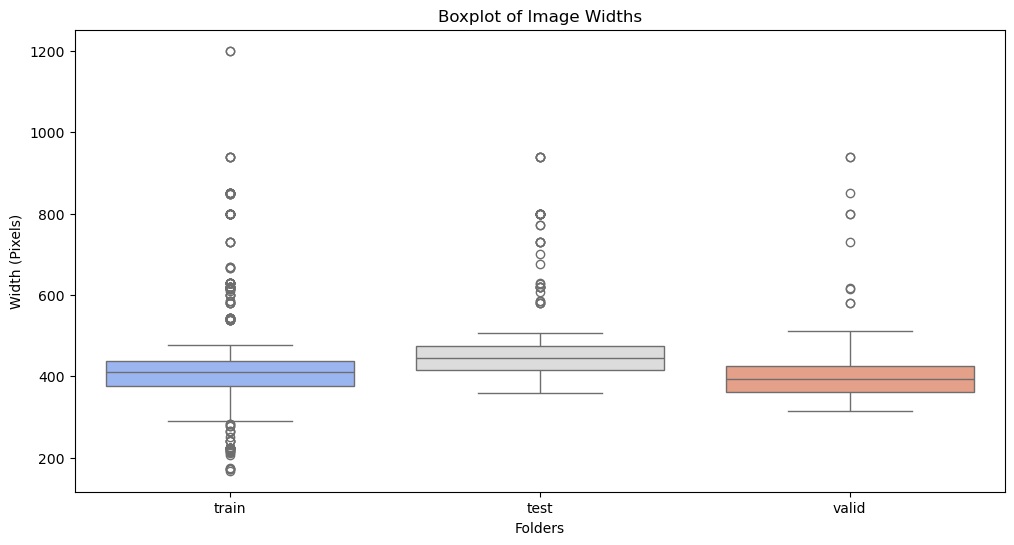

C:\Users\yoshi\AppData\Local\Temp\ipykernel_11292\100258017.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=image_sizes_df, x='Dataset', y='Height', palette='coolwarm')


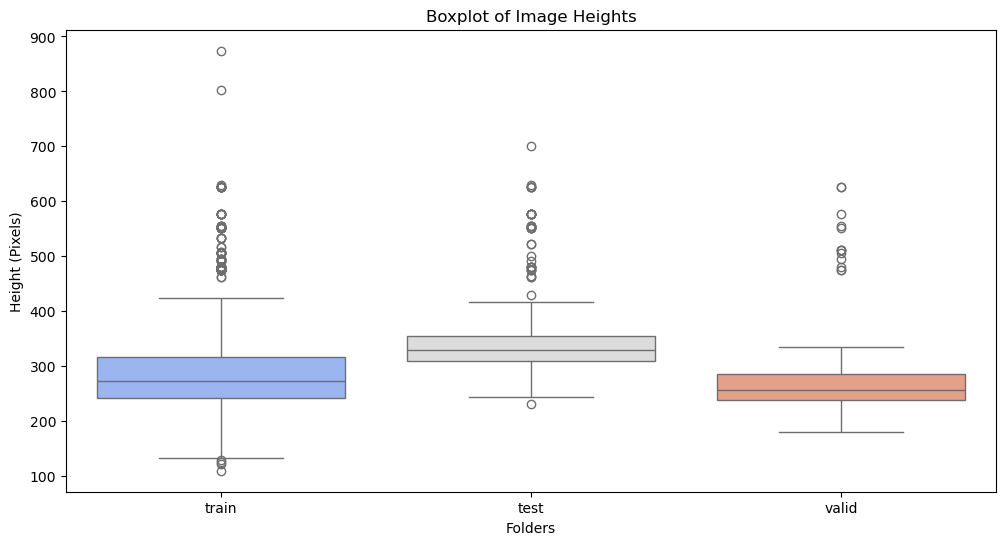

Summary statistics for image dimensions by dataset:
         Width                                                               \
         count        mean         std    min    25%    50%     75%     max   
Dataset                                                                       
test     315.0  470.825397  107.382218  360.0  416.0  444.0  475.00   940.0   
train    613.0  435.836868  133.486381  168.0  377.0  410.0  438.00  1200.0   
valid     72.0  437.763889  139.615518  315.0  360.5  392.5  425.75   940.0   

        Height                                                               
         count        mean         std    min     25%    50%     75%    max  
Dataset                                                                      
test     315.0  350.107937   80.377103  232.0  309.00  330.0  355.50  700.0  
train    613.0  303.314845  106.283336  110.0  243.00  273.0  316.00  874.0  
valid     72.0  299.486111  115.085638  181.0  237.75  256.0  286.75  627.0  


In [111]:
# Specify paths to dataset folders
image_folders = ['../data/train', '../data/test', '../data/valid']

# Init lists to store image dimensions and dataset type (train/test/valid)
image_widths = []
image_heights = []
dataset_types = []

# loop through folders
for folder in image_folders:
    dataset_type = os.path.basename(folder)
    for root, _, files in os.walk(folder):
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg')): 
                image_path = os.path.join(root, file)
                try:
                    with Image.open(image_path) as img:
                        image_widths.append(img.width)
                        image_heights.append(img.height)
                        dataset_types.append(dataset_type)
                except Exception as e:
                    print(f"Error loading image {image_path}: {e}")

# DataFrame for visualisation
image_sizes_df = pd.DataFrame({
    'Width': image_widths,
    'Height': image_heights,
    'Dataset': dataset_types
})

# Boxplot for Image Widths by Dataset
plt.figure(figsize=(12, 6))
sns.boxplot(data=image_sizes_df, x='Dataset', y='Width', palette='coolwarm')
plt.title('Boxplot of Image Widths')
plt.ylabel('Width (Pixels)')
plt.xlabel('Folders')
plt.show()

# Boxplot for Image Heights by Dataset
plt.figure(figsize=(12, 6))
sns.boxplot(data=image_sizes_df, x='Dataset', y='Height', palette='coolwarm')
plt.title('Boxplot of Image Heights')
plt.ylabel('Height (Pixels)')
plt.xlabel('Folders')
plt.show()

# summary statistics for image sizes by dataset
print("Summary statistics for image dimensions by dataset:")
print(image_sizes_df.groupby('Dataset')[['Width', 'Height']].describe())


# EDA


In [114]:
df.describe()

,GENDER,AGE,SMOKING,YELLOW FINGERS,ANXIETY,PEER PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,LUNG CANCER
count,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000
mean,0.514493,62.909420,0.543478,0.576087,0.496377,0.507246,0.521739,0.663043,0.547101,0.547101,0.550725,0.576087,0.630435,0.467391,0.557971,0.862319
std,0.500698,8.379355,0.499011,0.495075,0.500895,0.500856,0.500435,0.473529,0.498681,0.498681,0.498324,0.495075,0.483564,0.499842,0.497530,0.345191
min,0.000000,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,57.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,1.000000,62.500000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000
75%,1.000000,69.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,87.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


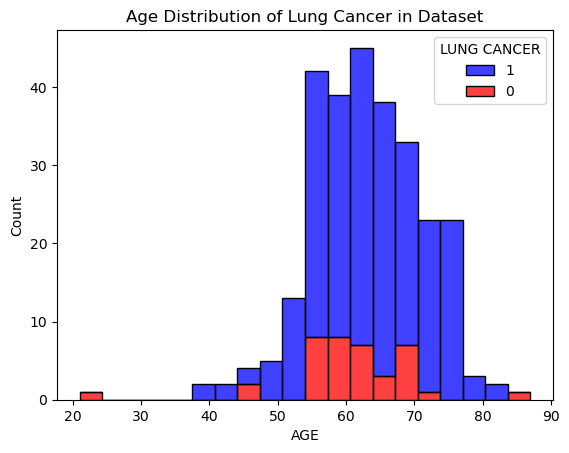

In [116]:
palette_colors = ['blue', 'red']
sns.histplot(data=df, x='AGE', hue='LUNG CANCER', multiple='stack', palette=palette_colors, hue_order=[1, 0])
plt.title('Age Distribution of Lung Cancer in Dataset')
plt.show()

In [118]:
corr_matrix = df.corr()

In [120]:
corr_matrix['LUNG CANCER'].sort_values(ascending=False)

LUNG CANCER              1.000000
ALLERGY                  0.333552
ALCOHOL CONSUMING        0.294422
SWALLOWING DIFFICULTY    0.268940
COUGHING                 0.253027
WHEEZING                 0.249054
PEER PRESSURE            0.195086
CHEST PAIN               0.194856
YELLOW FINGERS           0.189192
FATIGUE                  0.160078
ANXIETY                  0.144322
CHRONIC DISEASE          0.143692
AGE                      0.106305
SHORTNESS OF BREATH      0.064407
GENDER                   0.053666
SMOKING                  0.034878
Name: LUNG CANCER, dtype: float64

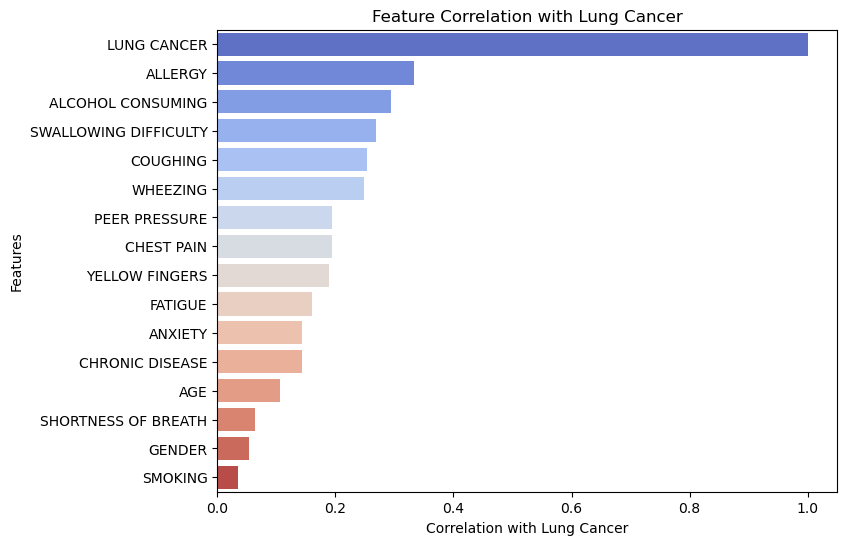

In [122]:
corr_df = corr_matrix['LUNG CANCER'].reset_index()
corr_df.columns = ['Feature', 'Correlation']
corr_df = corr_df.sort_values(by='Correlation', ascending=False)

# Plotting the correlation values intoa  bar chart
plt.figure(figsize=(8, 6))
sns.barplot(data=corr_df, x='Correlation', y='Feature', hue='Feature', dodge=False, palette='coolwarm', legend=False)
plt.xlabel('Correlation with Lung Cancer')
plt.ylabel('Features')
plt.title('Feature Correlation with Lung Cancer')
plt.show()


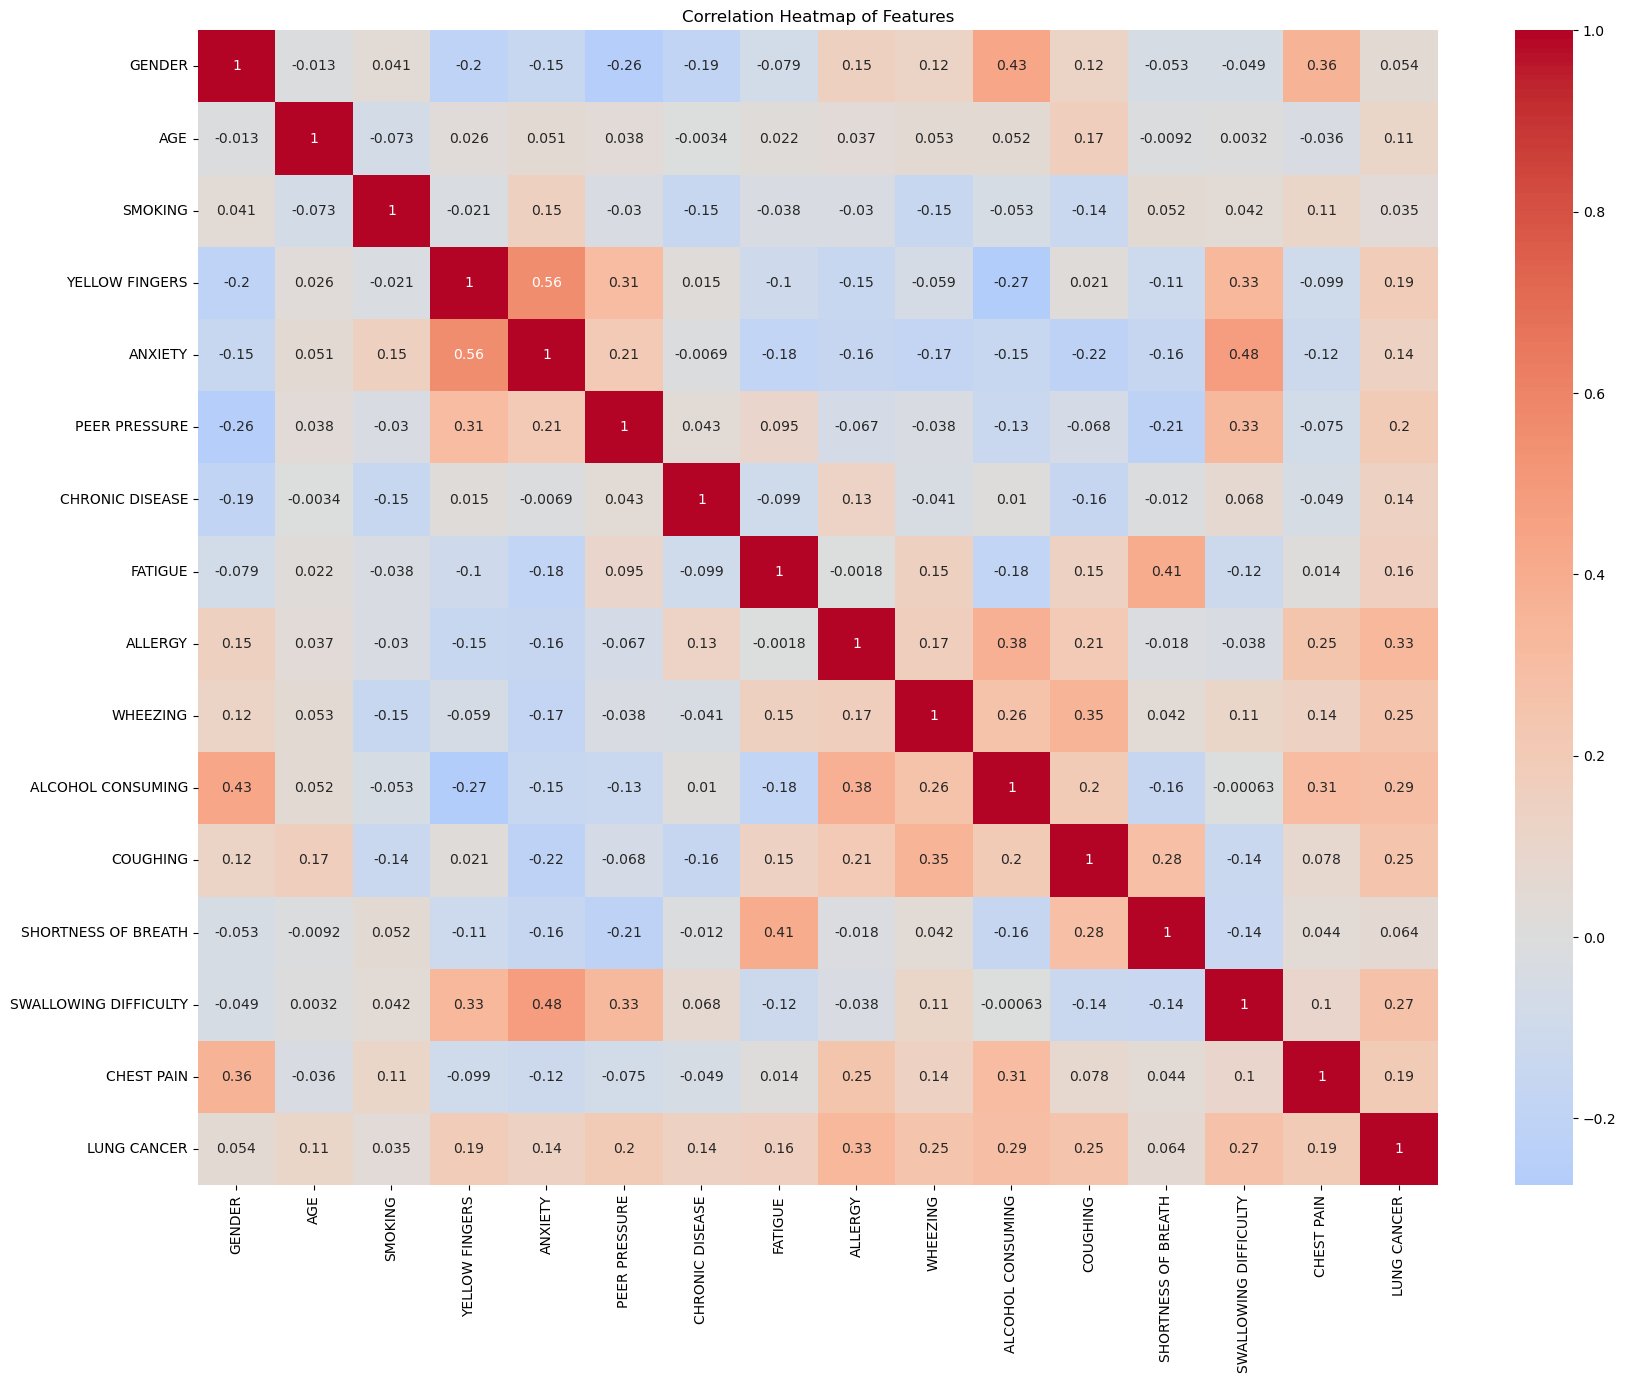

In [124]:
plt.figure(figsize=(20, 15))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap of Features')
plt.show()